# Projet : Prédiction de la consommation énergétique des appareils électroménagers

Ce notebook a été réalisé dans le cadre du projet de fin de semestre du cours **d’Apprentissage Statistique**. Il vise à mettre en œuvre, sur un cas concret, les notions étudiées pendant le semestre, notamment autour de la régression supervisée.

**Binôme :** Issa KA (<issa.ka@etu.sorbonne-universite.fr>) & Clara Garcia Pérez (<clara.garcia_perez@etu.sorbonne-universite.fr>)  
**Date de rendu :** 30 avril 2025  


# 1. Contexte et objectif

L’objectif de ce projet est de développer un **notebook Python** illustrant :

- La **lecture** et l’**analyse exploratoire** d’un jeu de données réelles ;
- La **mise en place** et la **comparaison** de plusieurs méthodes de régression (linéaire, Ridge, réseau de neurones dense) ;
- La **compréhension** de l’impact des **hyperparamètres** et des **choix de pré‑traitement** sur les performances.

**Données** :  
- Source : UCI ML – Energy Efficiency Data Set  
  https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv  
- Objectif : prédire `Appliances` (Wh) toutes les 10 minutes à partir de mesures ambiantes (températures, humidités, météo, lumière…).


<br>**Référence** :  
> - Candanedo et al., *Data driven prediction models of energy use of appliances in a low-energy house*, *Energy & Buildings* 2017  

In [1]:
# Versions 
import sys
print("Python   :", sys.version.splitlines()[0])
print("Pandas   :", __import__("pandas").__version__)
print("NumPy    :", __import__("numpy").__version__)
print("scikit‑learn:", __import__("sklearn").__version__)
print("Pytorch  :", __import__("torch").__version__)

Python   : 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
Pandas   : 2.2.2
NumPy    : 1.26.4
scikit‑learn: 1.5.1
Pytorch  : 2.6.0.dev20241108


# 2. Chargement et premier aperçu 

In [2]:
# importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils as ut
import importlib
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics         import mean_squared_error, mean_absolute_error, r2_score
importlib.reload(ut)

<module 'utils' from 'c:\\Users\\cheri\\nsi\\M1\\energy_consumption_prediction\\utils.py'>

In [3]:
# Load the dataset
df = pd.read_csv(
    "energydata_complete.csv",
    parse_dates=["date"],     # convert date column to datetime
    index_col="date"          # set date as index
)

In [4]:
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [5]:
print("Informations sur le DataFrame :\n")
df.info()

Informations sur le DataFrame :

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 n

In [6]:
print(f"Dimensions : {df.shape[0]} lignes et {df.shape[1]} colonnes")

Dimensions : 19735 lignes et 28 colonnes


**Premier aperçu** :
- **Granularité temporelle** : 10 minutes.  
- **Période couverte** : ~137 jours donc 4 mois (janvier–mai 2016).  
- **Nombre d’observations** : 19 735 
- **valeurs manquantes** : 0
- **Nombre de variables** :  
  - 1 cible : `Appliances` (Wh)  
  - 1 variable temporelle : `date` (timestamp)
  - 27 variables explicatives (temperatures, humidités, météo…)  

# 3. Analyse descriptive

Avant toute analyse, on commence par **supprimer** les deux variables aléatoires créées pour le filtrage (`rv1`, `rv2`), qui n’apportent rien à l’exploration.

In [7]:
# Delete the columns 'rv1' and 'rv2' as they are not needed for the analysis
df = df.drop(columns=['rv1', 'rv2'])

In [8]:
# new shape after dropping columns
df.shape

(19735, 26)

On a maintenant 25 **variables explicatives** 

**Description des variables** :

| Variable       | Description                                                      | Unité   |
|----------------|------------------------------------------------------------------|---------|
| **date**       | Date et heure (AAAA‑MM‑JJ HH:MM:SS)                              | –       |
| **Appliances** | Consommation énergétique des appareils ménagers                  | Wh      |
| **lights**     | Consommation énergétique de l’éclairage                          | Wh      |
| **T1**         | Température dans la cuisine                                      | °C      |
| **RH_1**       | Humidité relative dans la cuisine                                | %       |
| **T2**         | Température dans le salon                                        | °C      |
| **RH_2**       | Humidité relative dans le salon                                  | %       |
| **T3**         | Température dans la buanderie                                    | °C      |
| **RH_3**       | Humidité relative dans la buanderie                              | %       |
| **T4**         | Température dans le bureau                                       | °C      |
| **RH_4**       | Humidité relative dans le bureau                                 | %       |
| **T5**         | Température dans la salle de bain                                | °C      |
| **RH_5**       | Humidité relative dans la salle de bain                          | %       |
| **T6**         | Température extérieure (côté nord du bâtiment)                   | °C      |
| **RH_6**       | Humidité relative extérieure (côté nord du bâtiment)             | %       |
| **T7**         | Température dans la pièce de repassage                           | °C      |
| **RH_7**       | Humidité relative dans la pièce de repassage                     | %       |
| **T8**         | Température dans la chambre adolescente 2                         | °C      |
| **RH_8**       | Humidité relative dans la chambre adolescente 2                   | %       |
| **T9**         | Température dans la chambre des parents                          | °C      |
| **RH_9**       | Humidité relative dans la chambre des parents                    | %       |
| **T_out**      | Température extérieure (aéroport à proximité)                    | °C      |
| **Press_mm_hg**| Pression atmosphérique                                           | mm Hg   |
| **RH_out**     | Humidité relative extérieure                                     | %       |
| **Windspeed**  | Vitesse du vent                                                  | m/s     |
| **Visibility** | Visibilité                                                       | km      |
| **Tdewpoint**  | Température du point de rosée                                    | °C      |

## 3.1 Statistiques descriptives globales

In [9]:
stats = df.describe().T.round(2) # Transpose the summary and round the values to 2 decimal places
stats

,count,mean,std,min,25%,50%,75%,max
Appliances,19735.0,97.69,102.52,10.00,50.00,60.00,100.00,1080.00
lights,19735.0,3.80,7.94,0.00,0.00,0.00,0.00,70.00
T1,19735.0,21.69,1.61,16.79,20.76,21.60,22.60,26.26
RH_1,19735.0,40.26,3.98,27.02,37.33,39.66,43.07,63.36
T2,19735.0,20.34,2.19,16.10,18.79,20.00,21.50,29.86
RH_2,19735.0,40.42,4.07,20.46,37.90,40.50,43.26,56.03
T3,19735.0,22.27,2.01,17.20,20.79,22.10,23.29,29.24
RH_3,19735.0,39.24,3.25,28.77,36.90,38.53,41.76,50.16
T4,19735.0,20.86,2.04,15.10,19.53,20.67,22.10,26.20
RH_4,19735.0,39.03,4.34,27.66,35.53,38.40,42.16,51.09


**Interprétation des statistiques globales**
1. **Variable cible `Appliances`**  
   - **Moyenne** ≃ 98 Wh, **écart‑type** ≃ 102 Wh : forte dispersion, signe d’alternance entre périodes calmes et pointes de consommation.  
   - **Minimum** à 10 Wh, **maximum** à 1080 Wh : présence de valeurs extrêmes (pics de consommation) qui pourraient influencer la modélisation.

2. **Éclairage `lights`**  
   - Moyenne faible (≈ 3.8 Wh), très souvent nulle (**médiane** 0, **75 %** des observations à 0) avec quelques pointes jusqu’à 70 Wh : usage occasionnel, potentiellement indicateur d’occupation.

3. **Températures intérieures (`T1` à `T5`, `T7` à `T9`)**  
   - Globalement comprises entre 15 et 30 °C, **moyennes** entre 19 et 22 °C, avec une faible variabilité (écart‑type ≃ 1.5 à 2.5 °C).  
   - Indique un bon niveau d’isolation et un contrôle thermique efficace à l’intérieur.

4. **Humidité relative intérieure (`RH_1` à `RH_5`, `RH_7` à `RH_9`)**  
   - Moyennes généralement entre 35 % et 50 %, sauf en salle de bain (`RH_5`) où l’humidité peut monter à 96 %.  
   - Des pics d’humidité dans certaines pièces peuvent signaler l’usage intensif de douches, machines ou autres appareils électroménager.

5. **Indicateurs extérieurs**  
   - **T6** (température nord du bâtiment) : moyenne ≃ 7.9 °C, varie de −6 °C à +28 °C ; **RH_6** : moyenne ≃ 54.6 %, de 1 % à 99.9 %.  
   - **T_out** (météo aéroport) : moyenne ≃ 7.4 °C, de −5 °C à +26 °C.  
   - Vent modéré (moyenne ≃ 4 m/s, max 14 m/s), visibilité majoritairement élevée (> 40 km), pression stable autour de 755 mm Hg.

> Ces premières statistiques révèlent une **forte hétérogénéité** de la consommation `Appliances`, des **conditions intérieures relativement stables** et des **indicateurs extérieurs** plus variables. Nous allons poursuivre ces analyse pour prendre en compte ces éléments dans la modélisation.

## 3.2 Analyse de la cible `Appliances`

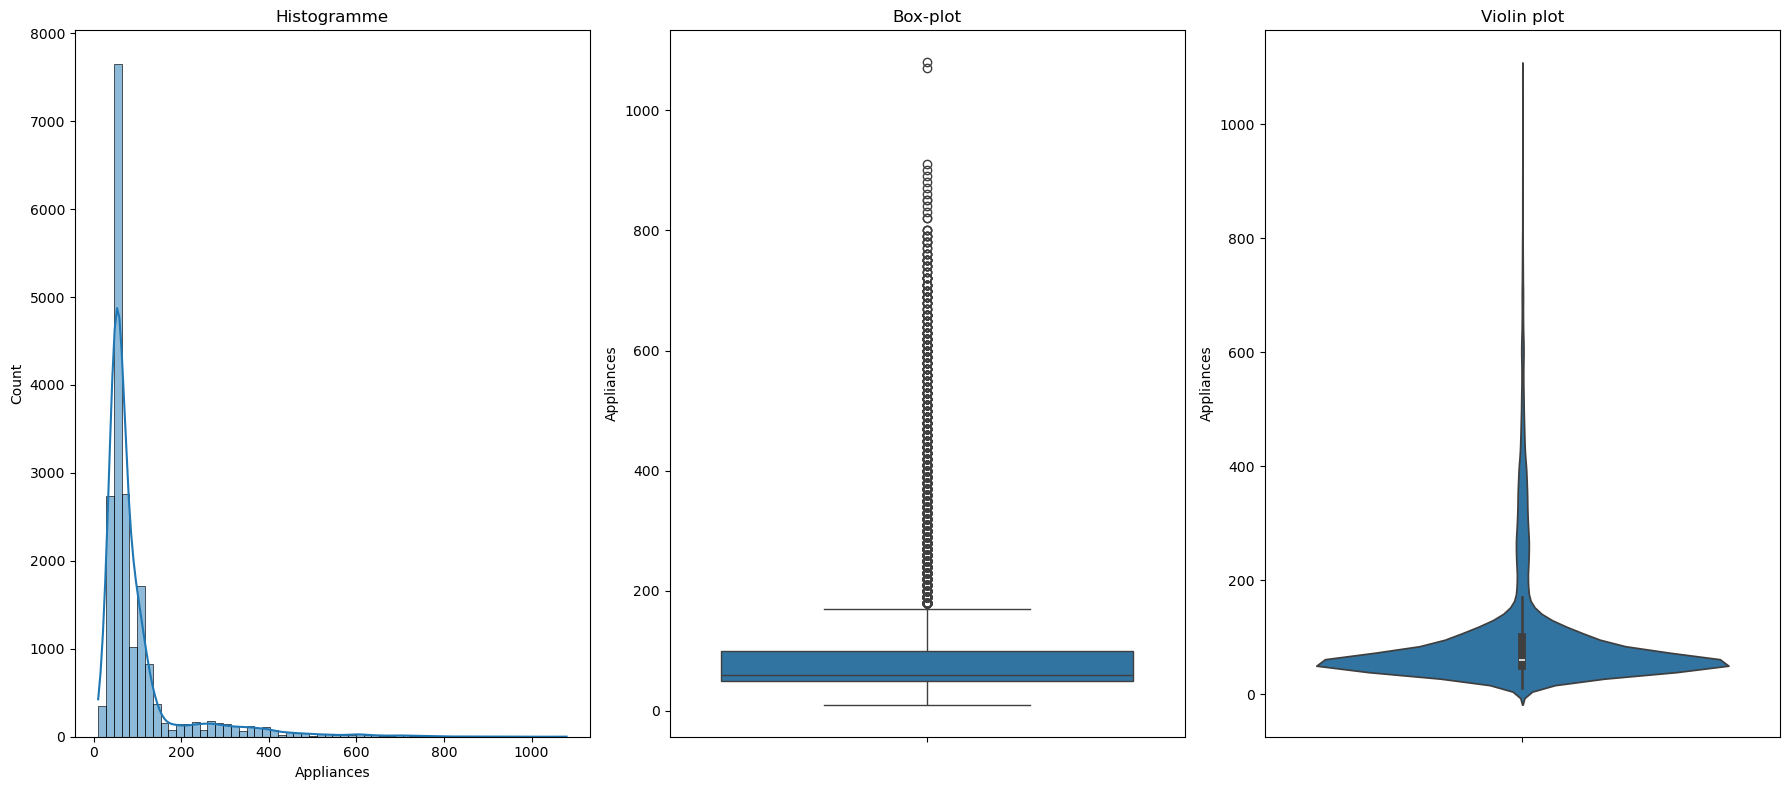

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# Histogram
sns.histplot(df['Appliances'], bins=60, kde=True, ax=axes[0])
axes[0].set_title("Histogramme")

# Boxplot
sns.boxplot(y=df['Appliances'], ax=axes[1])
axes[1].set_title("Box‑plot")

# Violin plot
sns.violinplot(y=df['Appliances'], ax=axes[2])
axes[2].set_title("Violin plot")

plt.tight_layout()
plt.show()


Cela confirme et précise les conclusions précédentes sur la consommation `Appliances` :
- **Distribution très asymétrique**  
  - La majorité des valeurs se concentre entre 10 Wh et 150 Wh (histogramme), avec une longue queue à droite jusqu’à ≃ 1 080 Wh.  
  - La **médiane** (~ 60 Wh) est inférieure à la **moyenne** (~ 98 Wh) : les rares pointes élevées tirent la moyenne vers le haut.

- **Outliers marqués**  
  - Le box‑plot montre de nombreux points au‑dessus du 75ᵉ quantile (~ 100 Wh) et des valeurs extrêmes autour de 800–1 000 Wh.  
  - Ces pointes peuvent correspondre à des appareils gros consommateurs (lave‑linge, four), des périodes de forte occupation ou des erreurs de mesure.


On créé des variables catégorielles temporelles pour mieux comprendre la consommation `Appliances` :
- `dayofweek` : jour de la semaine (0 = lundi, 6 = dimanche)
- `hour` : heure de la journée (0–23)

On envisage aussi de les utiliser comme variables explicatives dans la modélisation. 

In [11]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek  # 0 = lundi…6 = dimanche


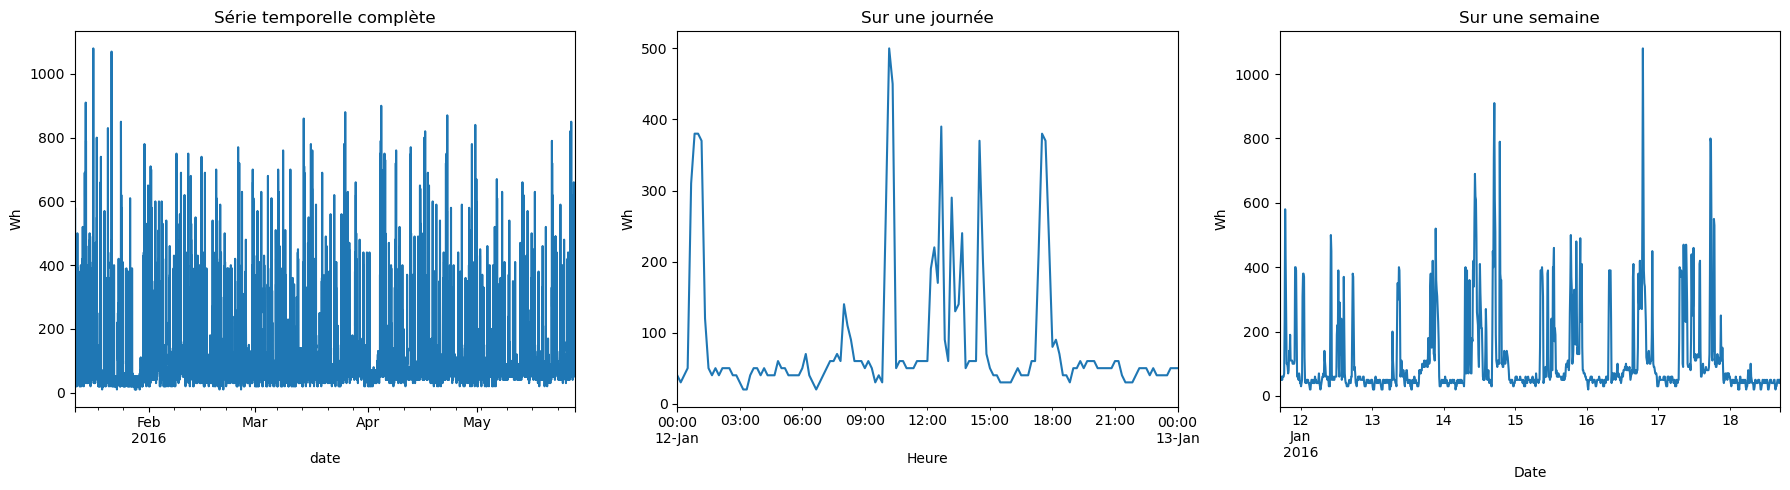

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# time series on the complete dataset
df['Appliances'].plot(ax=axes[0])
axes[0].set_title("Série temporelle complète")
axes[0].set_ylabel("Wh")

# time series on a day (first day of the dataset)
jour = df.loc[df.index[0]+ pd.Timedelta(hours=7):df.index[0] + pd.Timedelta(hours=7) + pd.Timedelta(days=1)] # because the first day starts at 17h
jour['Appliances'].plot(ax=axes[1])
axes[1].set_title("Sur une journée")
axes[1].set_xlabel("Heure")
axes[1].set_ylabel("Wh")

# time series on a week (first week of the dataset)
premiere_semaine = df.loc[(df.index >= df.index[0]) & (df.index < df.index[0] + pd.Timedelta(days=7))]
premiere_semaine['Appliances'].plot(ax=axes[2])
axes[2].set_title("Sur une semaine")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Wh")

plt.tight_layout()
plt.show()

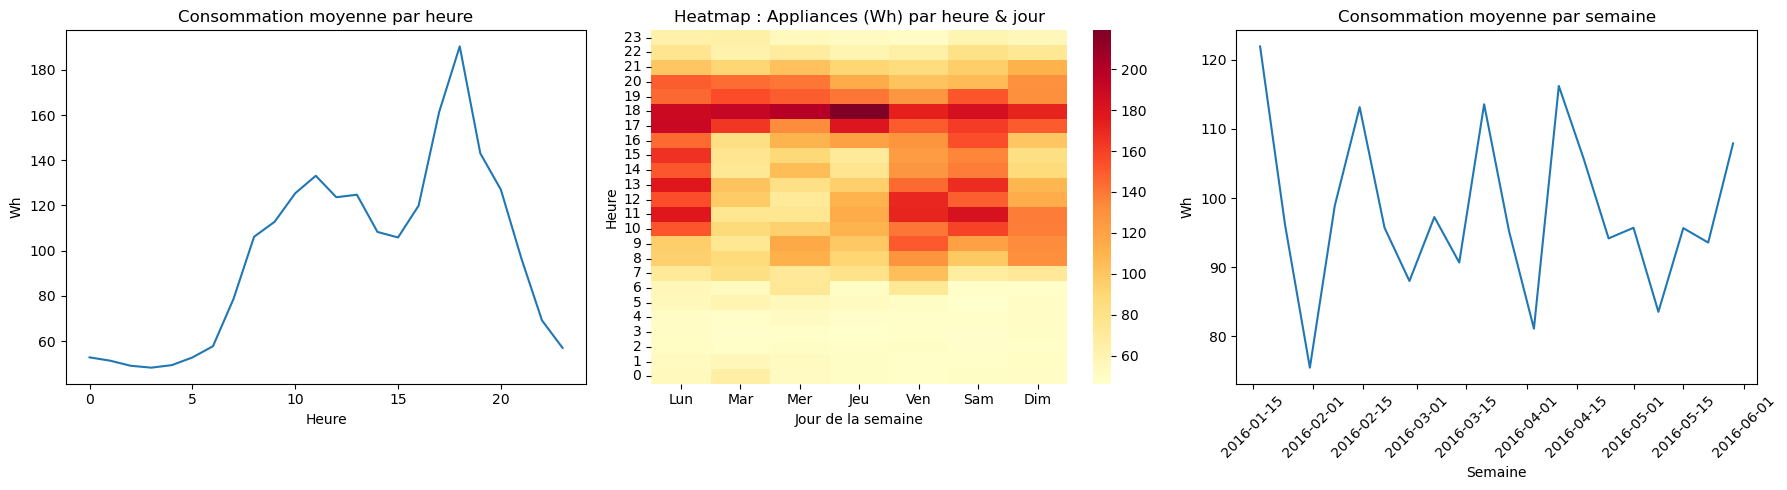

In [13]:
hourly = df.groupby('hour')['Appliances'].mean()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# average consumption per hour
sns.lineplot(x=hourly.index, y=hourly.values, ax=axes[0])
axes[0].set_title("Consommation moyenne par heure")
axes[0].set_xlabel("Heure")
axes[0].set_ylabel("Wh")

# heatpmap : Appliances (Wh) by hour & day of the week
pivot = df.pivot_table(index='hour', columns='dayofweek', values='Appliances', aggfunc='mean')
sns.heatmap(pivot.iloc[::-1], cmap='YlOrRd', annot=False,
            yticklabels=range(23, -1, -1), 
            xticklabels=['Lun','Mar','Mer','Jeu','Ven','Sam','Dim'], ax=axes[1])
axes[1].set_title("Heatmap : Appliances (Wh) par heure & jour")
axes[1].set_xlabel("Jour de la semaine")
axes[1].set_ylabel("Heure")

# average consumption per week
weekly = df.resample('W').Appliances.mean()
sns.lineplot(x=weekly.index, y=weekly.values, ax=axes[2])
axes[2].set_title("Consommation moyenne par semaine")
axes[2].set_xlabel("Semaine")
axes[2].set_ylabel("Wh")
for label in axes[2].get_xticklabels():
    label.set_rotation(45)

plt.tight_layout()
plt.show()

- **Comportements temporels réguliers**  
  - Les graphiques montrent une **consommation faible** la nuit, qui augmente le matin et atteint un **pic** à l’heure des repas (12h–14h) et en soirée (18h–20h).
  - Cela reflète un **usage domestique typique** : faible consommation la nuit, hausse lors des activités matinales, pic à l'heure des repas et en soirée.
  - La **volatilité** de la série temporelle complète confirme l’alternance entre périodes calmes et pics de consommation.
  - La **heatmap** révèle que ces pics sont présents tous les jours (surtout de 18 à 20h) mais pas de comportement très différent le **week-end**.
  - Il n’y a pas de **saisonnalité mensuelle** visible, car les données couvrent seulement 4 mois (janvier à mai) où la consommation reste relativement stable d’une semaine à l’autre.
  - La **variabilité intra-journalière** est bien plus forte que la variabilité entre jours de la semaine : l’**heure** est donc un facteur déterminant pour prédire la consommation.
  - la courbe **hebdomadaire** montre des fluctuations notables d’une semaine à l’autre autours d'une moyenne à 100Wh, traduisant une variabilité inter‑semaine non négligeable.  

> **Implications pour la modélisation**  
> - La **forte asymétrie** (skewness) et la présence d’**outliers** dans la distribution de `Appliances` suggèrent de tester une transformation (par exemple `log(Appliances)`) ou d’utiliser des modèles robustes (comme Lasso).  
> - Un **lissage** ou un **filtrage** des valeurs extrêmes pourrait améliorer la stabilité et la performance des modèles prédictifs.  
> - Les **pics récurrents** et la forte variabilité intra-journalière confirment l’intérêt de créer des **features temporelles** (`hour`, `dayofweek`) et éventuellement des lags pour capturer les cycles d’usage.  
> - La **heatmap** nous encourage à créer des **indicateurs** du type jour vs nuit
> - Une **moyenne mobile** pourrait être utile pour lisser les variations inter‑semaine et mieux capturer les tendances sous-jacentes.

## 3.3 Corrélations & relations entre variables

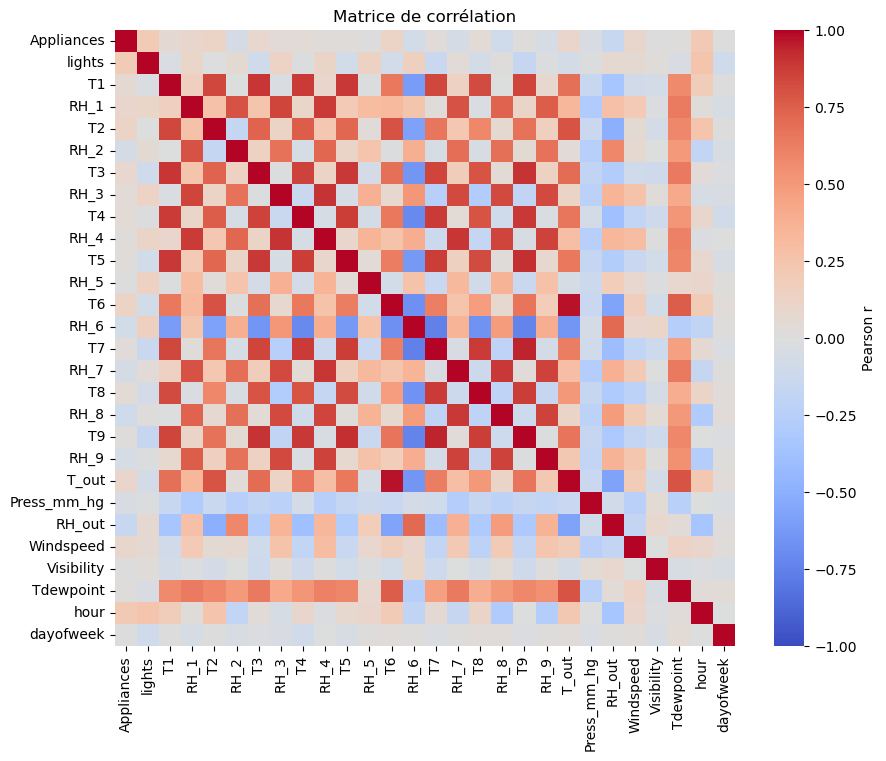

In [14]:
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', center=0, vmin=-1, vmax=1,
            cbar_kws={'label':'Pearson r'})
plt.title("Matrice de corrélation")
plt.show()

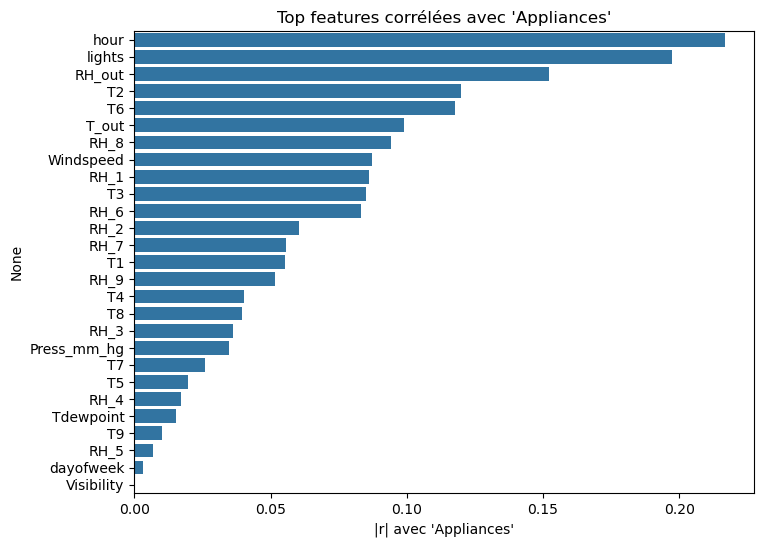

In [15]:
corr_target = df.corr()['Appliances'].abs().sort_values(ascending=False)[1:]
top_feats = corr_target.index

plt.figure(figsize=(8,6))
sns.barplot(y=top_feats, x=corr_target.values, orient='h')
plt.xlabel("|r| avec 'Appliances'")
plt.title("Top features corrélées avec 'Appliances'")
plt.show()

- Toutes les températures et humidités sont évidement extrêmement **corrélées** entre elles, il va donc falloir gérer cette **multicolinéarité** dans la modélisation.
- On remarque globalement peu de correlation avec la cible `Appliances`
- En revanche, `hour` est le facteur le plus corrélé avec `Appliances` (~22%) ce qui confirme l’importance de l’heure dans la consommation d’énergie.
- Aussi, `lights` et la température dans le salon `T2` ont une correlation de ~20% et 15% avec `Appliances`. Ils représentent de bons **indicateurs d'occupation** et donc de consommation d'énergie.
- l'humidité extérieur `RH_out` et les températures extérieurs `T_out` et `T6` sont aussi corrélée avec la cible (~15, ~12 et ~10% respectivement). 


> Pistes pour le feature engineering :  
>  - **ACP** ou **moyennes** pour réduire la multicolinéarité des variables de température et d’humidité.
>  - Créer un **indicateur d'occupation** à partir de `lights` et `T2`.

# 4. Feature engineering

On a déjà ajouté quelques features temporelles (`hour`, `dayofweek`), on va maintenant créer d’autres features et on analysera leur impact sur les performances des modèles.

### 4.1 Indicateur d'occupation

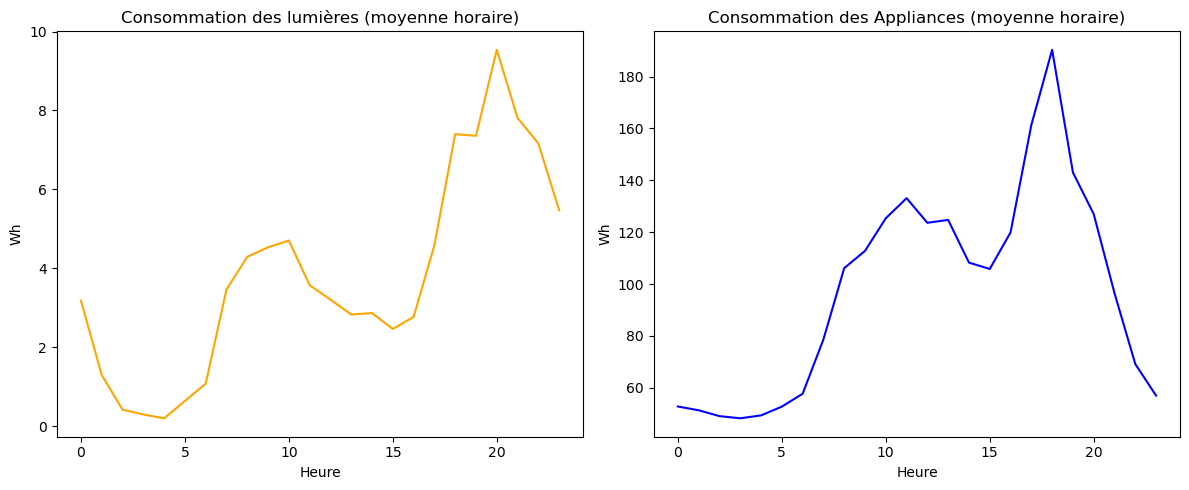

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Average occupancy by hour
df.groupby('hour')['lights'].mean().plot(ax=axes[0], color='orange')
axes[0].set_title("Consommation des lumières (moyenne horaire)")
axes[0].set_xlabel("Heure")
axes[0].set_ylabel("Wh")

# Average appliances by hour
df.groupby('hour')['Appliances'].mean().plot(ax=axes[1], color='blue')
axes[1].set_title("Consommation des Appliances (moyenne horaire)")
axes[1].set_xlabel("Heure")
axes[1].set_ylabel("Wh")

plt.tight_layout()
plt.show()


Le graphique horaire des consommations de `lights` (orange) et `Appliances` (bleu) révèle des profils presque identiques. 

Cela suggère que l’allumage des lumières est un excellent **proxy** de la présence d’occupants.

On va donc créer un indicateur binaire `occupancy` qui sera égal à 1 si `lights` > 0 et 0 sinon.

In [17]:
df['occupancy'] = (df['lights'] > 0).astype(int)

On dispose maintenant de deux régimes :
- **occupancy = 0** : pas de lumière allumée (probablement pas d’occupants ou endormis la nuit donc inactifs)  
- **occupancy = 1** : lumière allumée (présence d’occupants actifs)

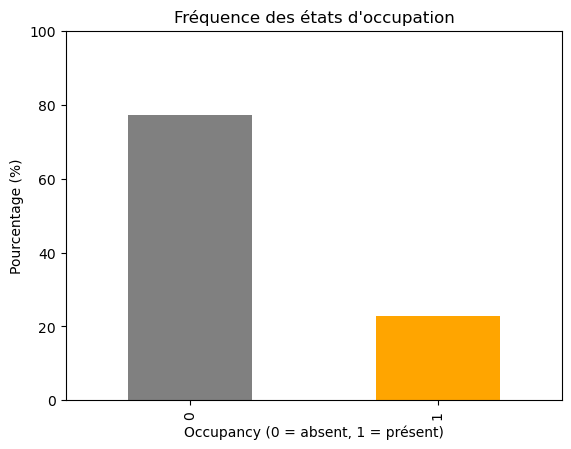

Répartition d'occupancy (en % des intervalles) :
occupancy
0    77.3%
1    22.7%
Name: proportion, dtype: object


In [18]:
# Frequency of occupancy
freq = df['occupancy'].value_counts(normalize=True).mul(100).round(1)

freq.plot(kind='bar', color=['gray', 'orange'])
plt.title("Fréquence des états d'occupation")
plt.xlabel("Occupancy (0 = absent, 1 = présent)")
plt.ylabel("Pourcentage (%)")
plt.ylim(0, 100)
plt.show()

print("Répartition d'occupancy (en % des intervalles) :")
print(freq.astype(str) + '%')

On constate que **occupancy = 1** n’apparaît que dans **20 %** des intervalles :  
- Assez fréquent pour être stabilisé en apprentissage  
- Assez rare pour segmenter nettement deux comportements de consommation

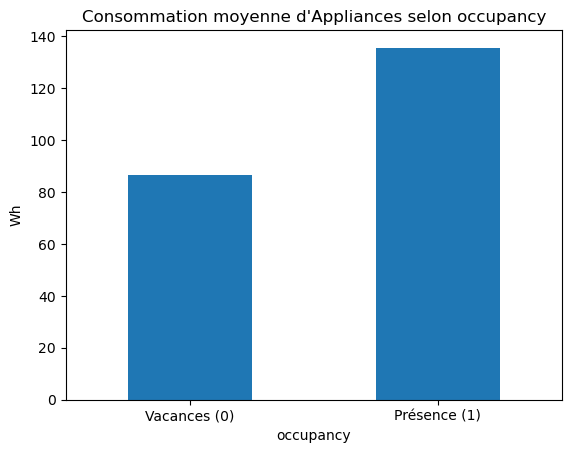


Consommation moyenne d'Appliances (Wh) :
occupancy
0     86.6
1    135.5
Name: Appliances, dtype: float64


In [19]:
mean_by_occ = df.groupby('occupancy')['Appliances'].mean().round(1)

mean_by_occ.plot(kind='bar')
plt.xticks([0,1], ['Vacances (0)', 'Présence (1)'], rotation=0)
plt.ylabel("Wh")
plt.title("Consommation moyenne d'Appliances selon occupancy")
plt.show()

print("\nConsommation moyenne d'Appliances (Wh) :")
print(mean_by_occ)

La différence est massive :
- **≈ 86 Wh** quand `occupancy = 0`  
- **≈ 135 Wh** quand `occupancy = 1`  

Cette dichotomie capture d’un seul coup une part importante de la variance de la cible, justifiant pleinement l’ajout de l’indicateur `occupancy`.

> **Conclusion :**
>  
> L’ajout de l’indicateur `occupancy` permet de distinguer deux régimes de consommation bien séparés (~80 % vs ~20 % des cas) et explique une grande partie de la variance de la cible, avec une consommation moyenne passant de ~86 Wh à ~135 Wh selon la présence d’occupants. Ce feature simple s’avère donc très pertinent pour la modélisation.  
>  
> On n’a pas besoin d’ajouter un indicateur temporel jour vs nuit, car `occupancy` capture déjà cette information.

### 4.2 Réduction de dimension 

Pour gérer la **multicolinéarité** des variables de température et d’humidité, on commence par visualiser leurs corrélations :

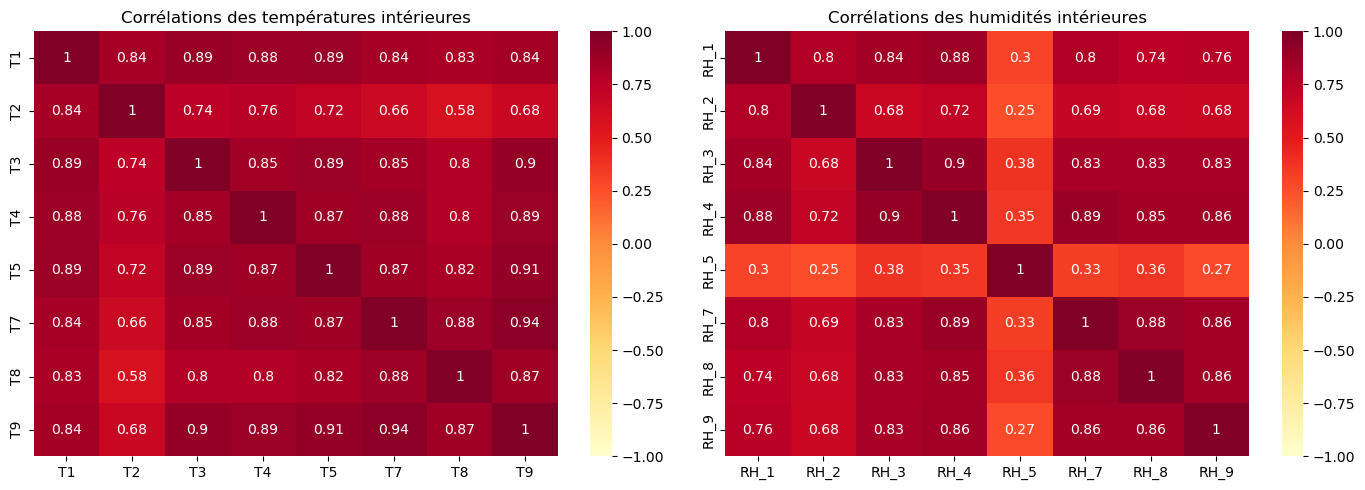

In [20]:
# Columns that represent the temperature and humidity inside the house
temp_cols = ['T1', 'T2', 'T3', 'T4', 'T5', 'T7', 'T8', 'T9']
hum_cols = ['RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_7', 'RH_8', 'RH_9']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correlation matrix of indoor temperatures
sns.heatmap(df[temp_cols].corr(), annot=True, center=0, vmin=-1, vmax=1, cmap='YlOrRd', ax=axes[0])
axes[0].set_title("Corrélations des températures intérieures")

# Correlation matrix of indoor humidities
sns.heatmap(df[hum_cols].corr(), annot=True, center=0, vmin=-1, vmax=1, cmap='YlOrRd', ax=axes[1])
axes[1].set_title("Corrélations des humidités intérieures")

plt.tight_layout()
plt.show()

Toutes ces corrélations sont très élevées (souvent > 0.8), ce qui indique un risque important de **multicolinéarité** pouvant nuire à la stabilité et l’interprétabilité des modèles linéaires.

Les seules variables qui se différencient un peu sont `T2` (température dans le salon) et `RH_5` (humidité dans la salle de bain). Ce qui est logique car le salon est un lieu de vie particulier et l'humidité de la salle de bain dépend quasiment uniquement de l'usage de la douche et prend des valeurs bien plus élevées que les autres pièces. 

On va donc appliquer une **Analyse en Composantes Principales (ACP)** sur chaque groupe pour réduire la dimension de ces variables tout en conservant l’essentiel de l’information.


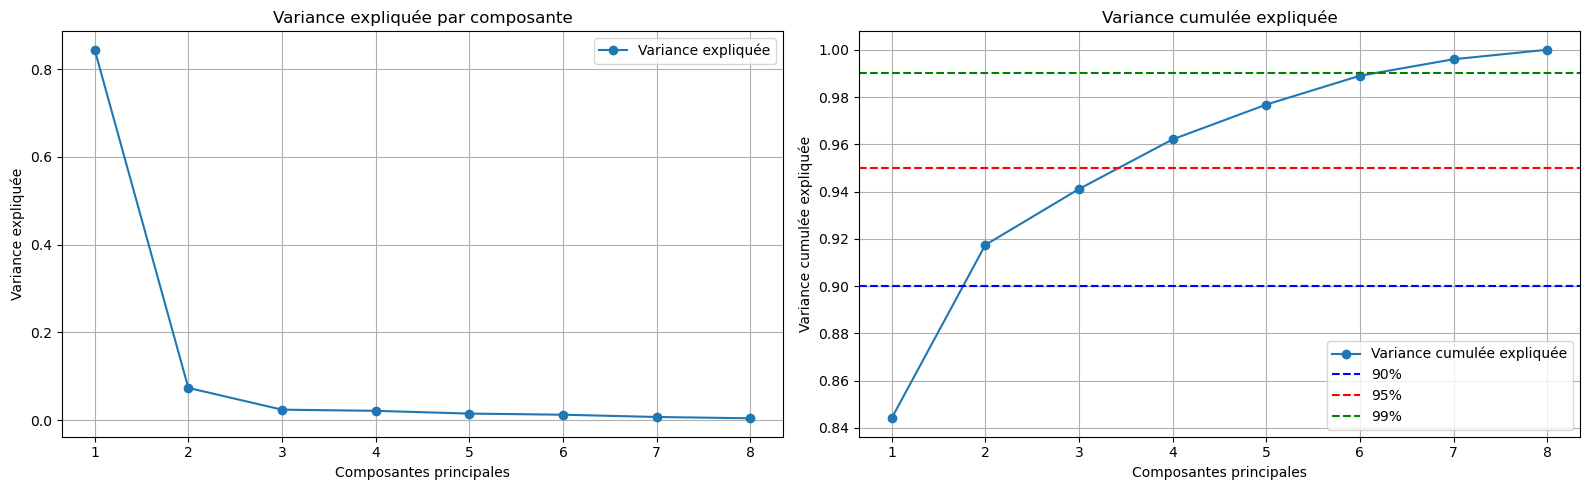

[0.84404304 0.91737796 0.94106173 0.96206803 0.97680183 0.98900026
 0.99599088 1.        ]


In [21]:
from sklearn.decomposition import PCA
import numpy as np

# PCA on the temperature columns
X_temp = df[temp_cols]
pca_temp = PCA().fit(X_temp)
explained_temp = pca_temp.explained_variance_ratio_
cumvar_temp = np.cumsum(explained_temp)


# Tracé de la variance expliquée et de la variance cumulée sur la même ligne
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Variance expliquée
axes[0].plot(range(1, len(explained_temp) + 1), explained_temp, marker='o', label='Variance expliquée')
axes[0].set_title("Variance expliquée par composante")
axes[0].set_xlabel("Composantes principales")
axes[0].set_ylabel("Variance expliquée")
axes[0].set_xticks(range(1, len(explained_temp) + 1))
axes[0].legend()
axes[0].grid()

# Variance cumulée expliquée
axes[1].plot(range(1, len(explained_temp) + 1), cumvar_temp, marker='o', label='Variance cumulée expliquée')
axes[1].set_title("Variance cumulée expliquée")
axes[1].set_xlabel("Composantes principales")
axes[1].set_ylabel("Variance cumulée expliquée")
axes[1].set_xticks(range(1, len(explained_temp) + 1))
axes[1].axhline(y=0.90, color='b', linestyle='--', label='90%')
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95%')
axes[1].axhline(y=0.99, color='g', linestyle='--', label='99%')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

print(cumvar_temp)



On choisi de garder **les 2 premières composantes principales** puisque elles expliquent **92%** de la variance totale et qu'à partir de la 3ème composante, les gains en variance sont **très faibles et diminuent rapdidement**.

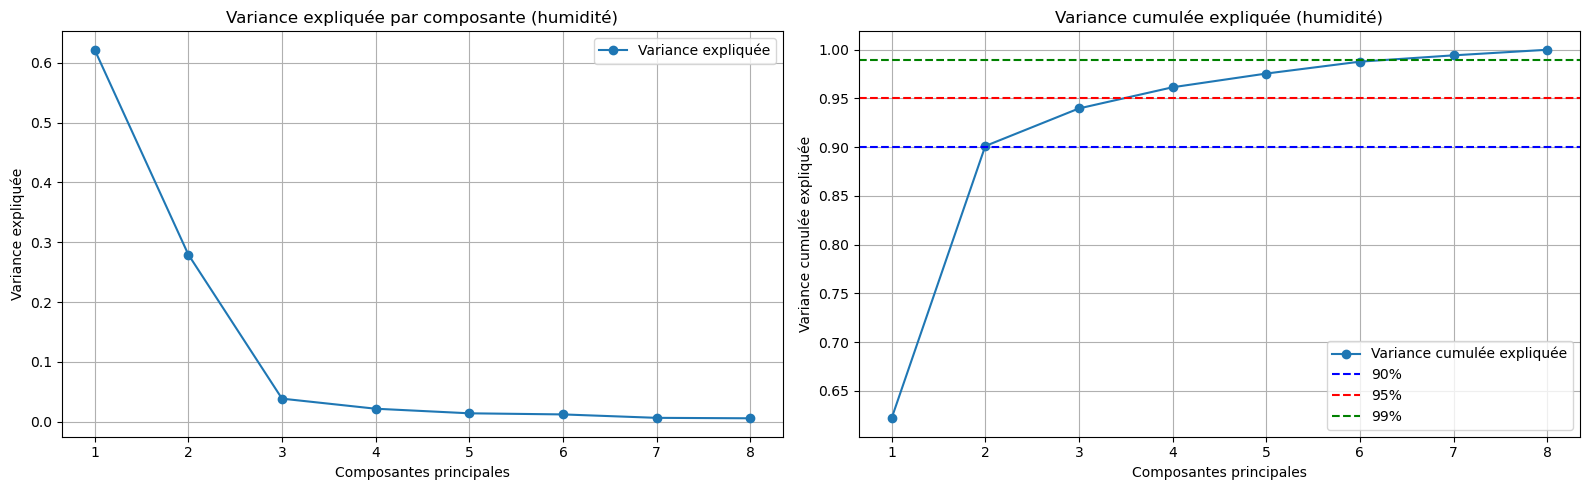

[0.62177835 0.90120466 0.93977558 0.96150808 0.97557611 0.98778643
 0.99427319 1.        ]


In [22]:
# ACP sur les colonnes d'humidité intérieure
X_hum = df[hum_cols]
pca_hum = PCA().fit(X_hum)
explained_hum = pca_hum.explained_variance_ratio_
cumvar_hum = np.cumsum(explained_hum)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Variance expliquée par composante
axes[0].plot(range(1, len(explained_hum) + 1), explained_hum, marker='o', label='Variance expliquée')
axes[0].set_title("Variance expliquée par composante (humidité)")
axes[0].set_xlabel("Composantes principales")
axes[0].set_ylabel("Variance expliquée")
axes[0].set_xticks(range(1, len(explained_hum) + 1))
axes[0].legend()
axes[0].grid()

# Variance cumulée expliquée
axes[1].plot(range(1, len(cumvar_hum) + 1), cumvar_hum, marker='o', label='Variance cumulée expliquée')
axes[1].set_title("Variance cumulée expliquée (humidité)")
axes[1].set_xlabel("Composantes principales")
axes[1].set_ylabel("Variance cumulée expliquée")
axes[1].set_xticks(range(1, len(cumvar_hum) + 1))
axes[1].axhline(y=0.90, color='b', linestyle='--', label='90%')
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95%')
axes[1].axhline(y=0.99, color='g', linestyle='--', label='99%')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

print(cumvar_hum)

Pour les même raisons, on garde aussi les **2 premières composantes**. Elles expliquent ici **90%** de la variance totale.

On va donc créer 4 nouvelles variables `PC_temp1`, `PC_temp2`, `PC_hum1` et `PC_hum2` qui seront les deux premières composantes principales de chaque groupe de variables.

In [23]:
temp_pcs = pca_temp.transform(df[temp_cols])
df['PC_temp1'] = temp_pcs[:, 0]
df['PC_temp2'] = temp_pcs[:, 1]

hum_pcs = pca_hum.transform(df[hum_cols])
df['PC_hum1'] = hum_pcs[:, 0]
df['PC_hum2'] = hum_pcs[:, 1]


>**Conclusion :**
>
> - Nous somme passer de **16** variables à **4** variables, ce qui réduit considérablement la **multicolinéarité** et est censé améliorer la **stabilité** des modèles linéaires. 
> - Nous avons gardé plus de **90%** de la variance totale dans les deux groupes. 
> - Nous testerons plus tard l'impact des ces nouvelles variables sur les performances des modèles.

### 4.3 Transformation de la cible

Comme on l'a vu précédemment, la distribution de la consommation `Appliances` est fortement asymétrique à droite et présente des outliers marqués :

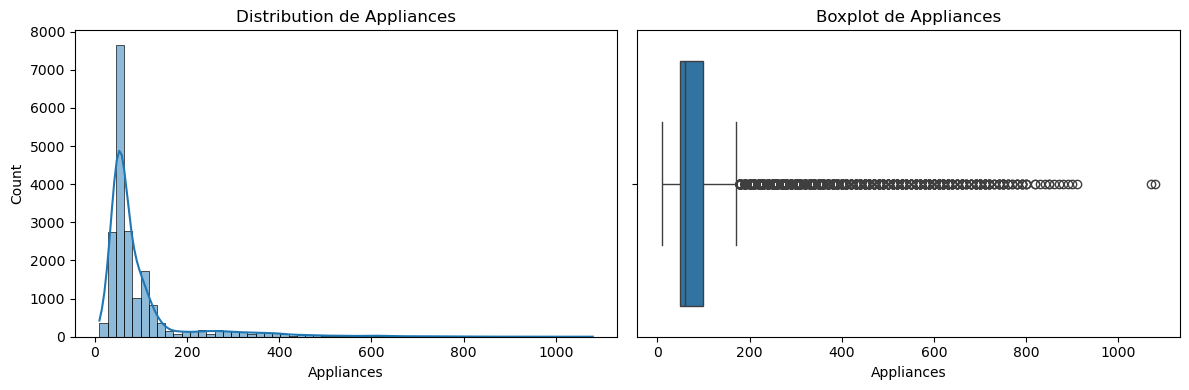

In [24]:
# Original distribution of Appliances
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df['Appliances'], bins=60, kde=True, ax=axes[0])
axes[0].set_title("Distribution de Appliances")
sns.boxplot(x=df['Appliances'], ax=axes[1])
axes[1].set_title("Boxplot de Appliances")
plt.tight_layout()
plt.show()

- **Asymétrie prononcée** (longue queue à droite)  
- **Variance non constante** (outliers très éloignés du corps principal)  
- Ces caractéristiques peuvent biaiser le **MSE** et violer **l’homoscédasticité** (variance non constante).

On le remarque aussi sur la série temporelle de `Appliances` qui présente une forte volatilité et des outliers marqués :

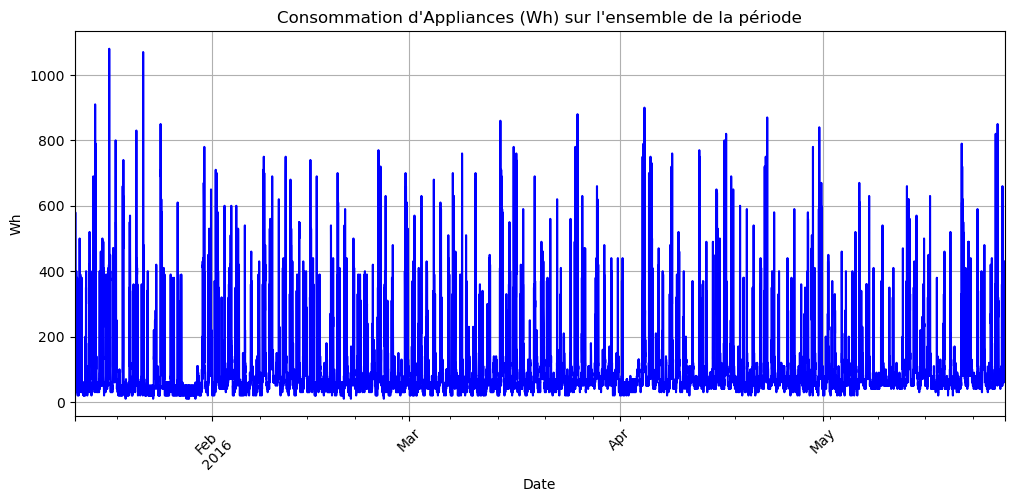

In [25]:
# Plot appliances complete time series
plt.figure(figsize=(12, 5))
df['Appliances'].plot(color='blue')
plt.title("Consommation d'Appliances (Wh) sur l'ensemble de la période")
plt.xlabel("Date")
plt.ylabel("Wh")
plt.xticks(rotation=45)
plt.grid()
plt.show()

On va donc appliquer une **transformation logarithmique** sur la cible `Appliances` pour réduire l’asymétrie et stabiliser la variance.

In [26]:
# Application du log-transform pour atténuer ces effets
df['log_Appliances'] = np.log1p(df['Appliances'])

# Mesure de la skewness avant/après
skew_orig = df['Appliances'].skew()
skew_log  = df['log_Appliances'].skew()
print(f"Skewness avant : {skew_orig:.2f}")
print(f"Skewness après : {skew_log:.2f}")

Skewness avant : 3.39
Skewness après : 1.19


La transformation `log1p` permet de :  
- **Réduire l’asymétrie** et rapprocher la distribution d’une forme plus gaussienne  
- **Stabiliser la variance**, améliorant l’homoscédasticité des résidus  
- Mieux modéliser les **effets multiplicatifs** (variation en pourcentage)

Distribution et série temporelle après transformation :

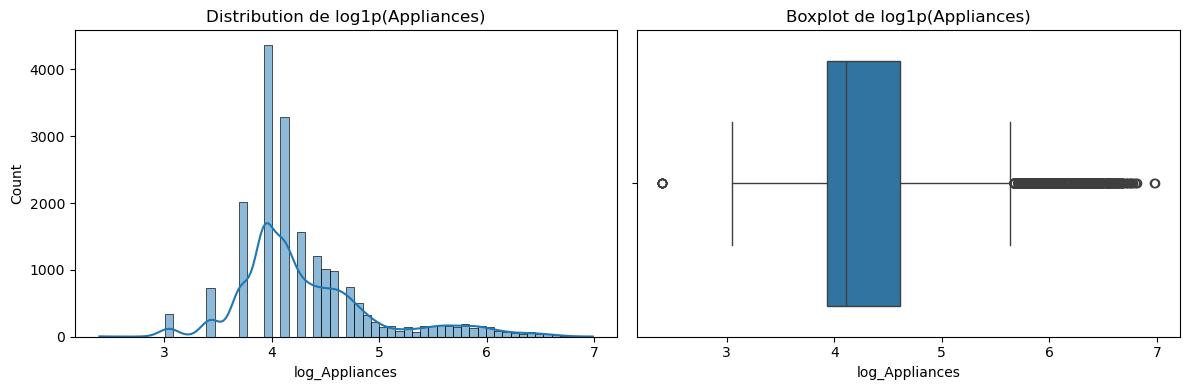

In [27]:
# Distribution après transformation
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df['log_Appliances'], bins=60, kde=True, ax=axes[0])
axes[0].set_title("Distribution de log1p(Appliances)")
sns.boxplot(x=df['log_Appliances'], ax=axes[1])
axes[1].set_title("Boxplot de log1p(Appliances)")
plt.tight_layout()
plt.show()

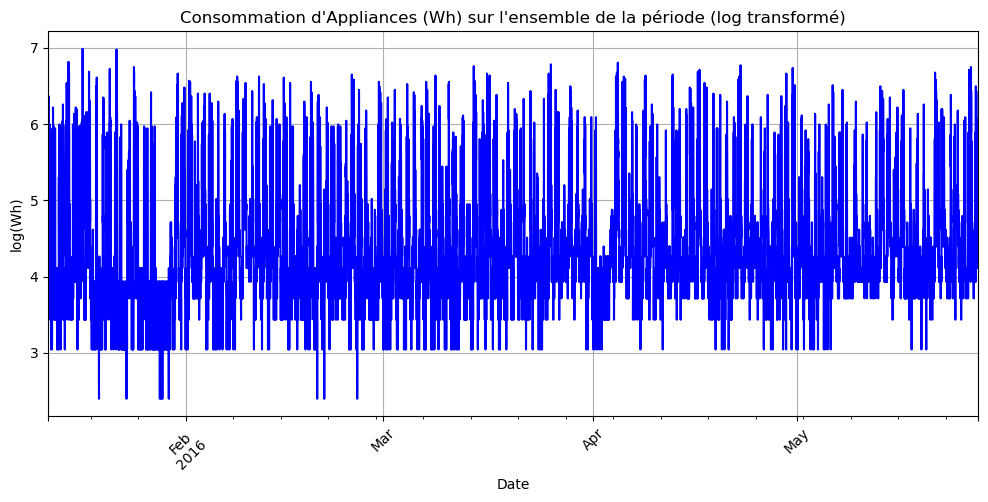

In [28]:
# Plot log transformed appliances time series
plt.figure(figsize=(12, 5))
df['Appliances'].apply(np.log1p).plot(color='blue')
plt.title("Consommation d'Appliances (Wh) sur l'ensemble de la période (log transformé)")
plt.xlabel("Date")
plt.ylabel("log(Wh)")
plt.xticks(rotation=45)
plt.grid()
plt.show()

> **Conclusion :**
>
> - Le `log1p` sur la cible rend la distribution plus **symétrique**
> - Il **atténue l’impact des valeurs extrêmes** et **stabilise la variance**
> - Cela se traduit généralement par de meilleures performances et une interprétation plus robuste des modèles de régression notamment linéaires. (On testera ce plus tard)
> - On remarque graphiquement ces changements : la distribution est plus symétrique et la série temporelle est plus lissée, ce qui est un bon signe pour la modélisation.
> - Mais, cette transformation **n'est pas parfaite** puisqu'il reste encore une légère asymétrie et des outliers.


### 4.4 Lags et statistiques glissantes

L’analyse descriptive a mis en évidence :  
- Une **forte autocorrélation intra-journalière** : la consommation à 10 min, 30 min ou 1 h d’intervalle reste très similaire.  
- Des **pics localisés** qui se prolongent sur plusieurs intervalles de temps (de plusieurs dizaines de minutes à plusieurs heures).  

Les **lags** exploitent ces propriétés :  
- **Mémoire du contexte** – fournir `Appliances_{t−k}` (k=1,6,12…) permet au modèle de prolonger les tendances récentes.  
- **Alerte précoce aux pics** – un pic à t−1 signale fortement qu’un pic à t est probable.  

Les **statistiques glissantes** (rolling) :  
- **Lissent** les fluctuations (moyennes mobiles)  
- Quantifient la **volatilité locale** (écart-type mobile)  


In [29]:
# Création de lags de la cible
lags = [1, 6, 12, 24]  # en pas de 10 min : 1→10 min, 6→1 h, 12→2 h, 24→4 h
for lag in lags:
    df[f'lag_{lag}'] = df['Appliances'].shift(lag)

Les lags ajoutent une **mémoire** temporaire :  
- `lag_1` capture l’effet “10 min avant”,  
- `lag_6` celui “1 h avant”, etc.  

In [30]:
# Rolling mean and std
windows = [6, 12, 24, 72]  # 1 h, 2 h, 4 h, 12 h
for w in windows:
    df[f'roll_mean_{w}'] = df['Appliances'].rolling(window=w, min_periods=1).mean()
    df[f'roll_std_{w}']  = df['Appliances'].rolling(window=w, min_periods=1).std().fillna(0)

- `roll_mean_w` : moyenne mobile sur `w × 10 min`,  
- `roll_std_w` : écart-type mobile → mesure la volatilité locale.  

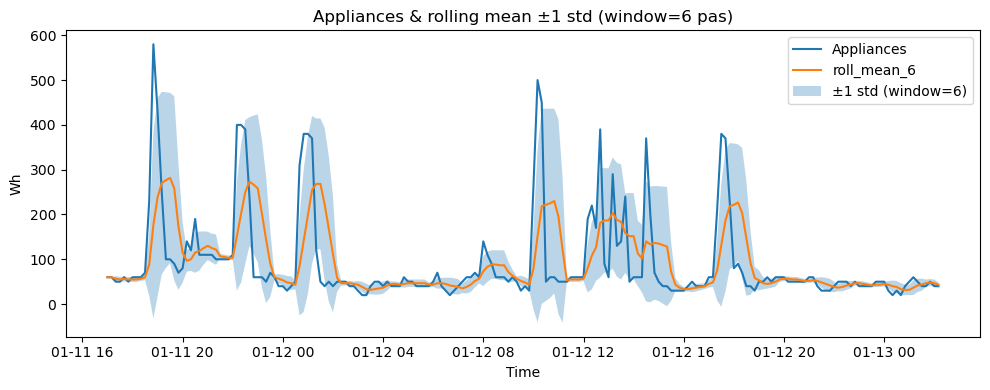

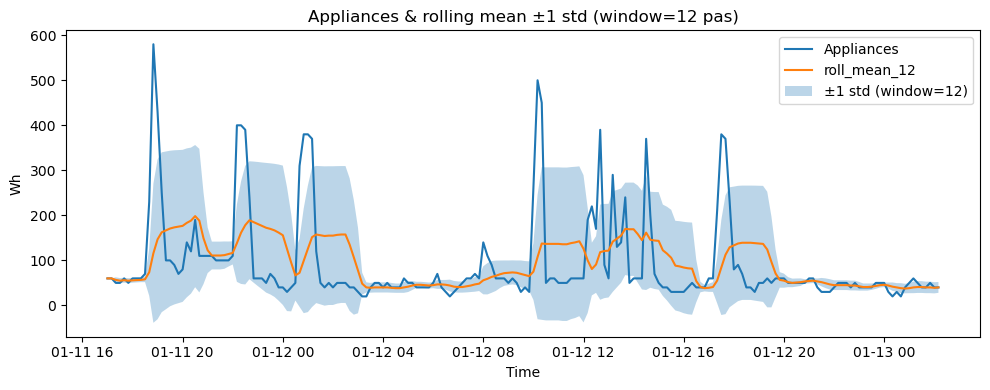

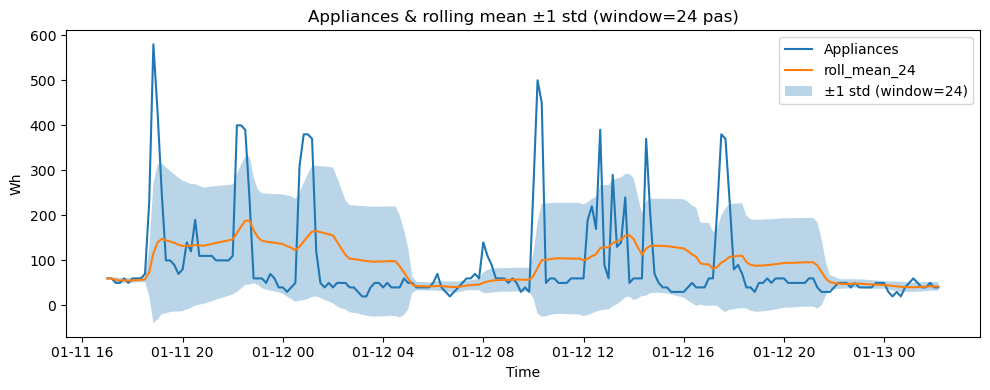

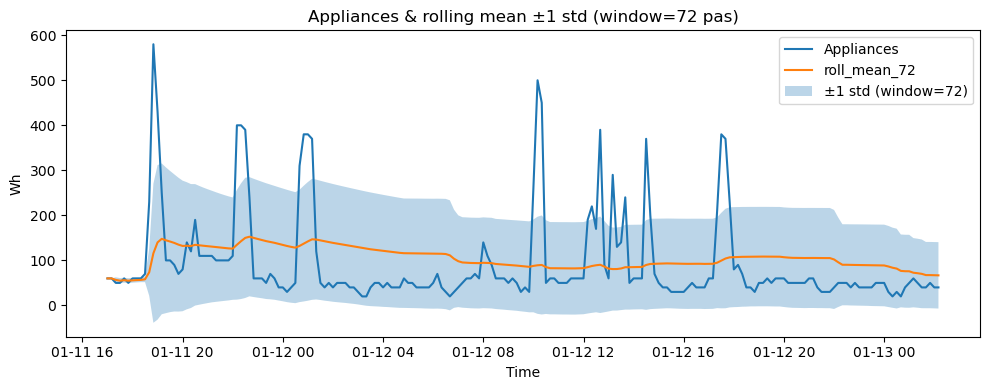

In [31]:
import matplotlib.pyplot as plt

# Fenêtres de calcul : 1h, 2h, 4h, 12h (en pas de 10 min)
windows = [6, 12, 24, 72]
n = 200  # nombre de points à afficher pour la lisibilité

for w in windows:
    # Calcul des rolling mean et rolling std
    roll_mean = df['Appliances'].rolling(window=w, min_periods=1).mean()
    roll_std  = df['Appliances'].rolling(window=w, min_periods=1).std().fillna(0)
    
    # Trace
    plt.figure(figsize=(10, 4))
    plt.plot(df.index[:n], df['Appliances'][:n], label='Appliances')
    plt.plot(df.index[:n], roll_mean[:n], label=f'roll_mean_{w}')
    plt.fill_between(
        df.index[:n],
        roll_mean[:n] - roll_std[:n],
        roll_mean[:n] + roll_std[:n],
        alpha=0.3,
        label=f'±1 std (window={w})'
    )
    
    plt.title(f'Appliances & rolling mean ±1 std (window={w} pas)')
    plt.xlabel('Time')
    plt.ylabel('Wh')
    plt.legend()
    plt.tight_layout()
    plt.show()


Les graphiques ci-dessus comparent la série brute `Appliances` à la **moyenne mobile** et à la bande **±1 écart-type** pour quatre tailles de fenêtres
(1, 2, 4 et 12h heures).

**Interprétation :**  
- Les **petites fenêtres** (1-2h) permettent de détecter et prolonger les **pics localisés**.  
- Les **grandes fenêtres** (4-12h) fournissent une **tendance de fond**, utile pour capturer les cycles jour/nuit ou la variation hebdomadaire.  
- L’**écart-type mobile** permet au modèle de quantifier la **volatilité locale**, renforçant la capacité à prédire l’intensité et la durée des pointes.

En combinant plusieurs tailles de fenêtres (`roll_mean_w`, `roll_std_w`), on apporte au modèle à la fois une mémoire fine des fluctuations rapides et une vision plus globale de la tendance, ce qui améliore la robustesse et la précision des prédictions.

>**Conclusion :**
>
> - les **lags** fournissent une mémoire contextuelle et alertent sur les pics prolongés
> - les **rolling stats** lissent le signal et mesurent la volatilité locale
> - Il faudra quand même vérifier que ces nouvelles variables ne créent pas de **multicolinéarité** avec les autres variables explicatives.
> - Il faudra surement utiliser des techniques de **regularisation** (Lasso, Ridge) pour éviter le sur-apprentissage.
> - Aussi, il faudra faire attention à la **taille de la fenêtre** choisie. 

### Conclusion de la partie 4 – Feature Engineering



En se basant sur notre exploration des données, nous les avons enrichi avec des indicateurs pertinents (occupation, temporalité, lags, moyennes mobiles, ACP, log). En se faisant, on a ajouté de la multicolinéarité et de la complexité au modèle. 

Dans les parties suivantes, nous allons : 
- entraîner nos différents algorithmes (linéaires, réseau de neurones, noyaux...) et comparer leurs performances avec et sans ces nouvelles variables. 
- on verras quelles variables sont plus ou moins importantes pour chaque algorithme, pourquoi et comment elles influencent la prédiction
- on aura donc pour chaque modèle un jeu de features optimal propre à ce modèle. 
- on essayera aussi de trouver les hyperparamètres optimaux pour chaque algorithme.

Ainsi, nous étudierons les spécificités de chaque algorithme tout en atteignant des performances (on l'espère) optimales.

# 5. Préparation des données

### 5.1 Nettoyage

En créant de nouvelles variables temporelles dans le feature engineering, on a introduit des **valeurs manquantes**. Il n'y en a pas beaucoup donc on va les supprimer.

In [ ]:
# Afficher le nombre de valeurs manquantes par colonne dans df
missing = df.isnull().sum()
print(missing[missing > 0])

# delete
df = df.dropna()

lag_1      1
lag_6      6
lag_12    12
lag_24    24
dtype: int64


In [ ]:
df.shape 

(19711, 46)

### 5.2 Définition des features-sets

Comme on l'a dit précédemment, on va juger la pertinence des features ajoutées en fonction des différents algorithmes. 

On ne pourra pas tester **toutes les combinaisons** possibles, ni **l'impact individuel** de chaque feature pour garder la longueur de ce notebook raisonnable. Mais on va essayer d'analyser ces features **par groupe**. 

Pour cela, on créé des **features-sets** qui contiennent les variables qu'on va utiliser pour chaque algorithme.
- `FS0` : toutes les variables explicatives de base (sans la partie feature engineering)
- `FS1` : `FS0` + les variables temporelles (`hour`, `dayofweek`) + l'indicateur d'occupation (`occupancy`) 
- `FS2` : `FS1` + l'acp sur les températures et humidités (sans les variables de base)
- `FS3` : `FS2` + les lags et rolling stats (moyennes mobiles et écart-type)

Ca nous permettra d'étudier l'apport incrémental du feature engineering.

On entrainera alors chaque algorithme sur ces 4 features-sets et on comparera les performances.

In [35]:
# FS0 : variables d’origine (sans temporalité ni PCA ni lags/rolling)
fs0 = [
    'lights', 'T1','RH_1','T2','RH_2','T3','RH_3','T4','RH_4',
    'T5','RH_5','T6','RH_6','T7','RH_7','T8','RH_8','T9','RH_9',
    'T_out','RH_out','Windspeed','Visibility','Tdewpoint','Press_mm_hg'
]

# FS1 : FS0 + indicateurs temporels et d’occupation
fs1 = fs0 + ['hour','dayofweek','occupancy']

# FS2 : FS1 + composantes principales (PCA) - température - humidité
temp_hum_cols = [
    'T1','RH_1','T2','RH_2','T3','RH_3','T4','RH_4',
    'T5','RH_5','T7','RH_7','T8','RH_8','T9','RH_9'
]
fs2 = [col for col in fs1 if col not in temp_hum_cols] + ['PC_temp1', 'PC_temp2', 'PC_hum1', 'PC_hum2']

# FS3 : FS2 + lags et statistiques glissantes
lags    = [1,6,12,24]     # en pas de 10 min
windows = [6,12,24,72]    # 1h, 2h, 4h, 12h
fs3 = fs2 + [f'lag_{l}' for l in lags] + [f'roll_mean_{w}' for w in windows] + [f'roll_std_{w}' for w in windows]

feature_sets = {'FS0': fs0, 'FS1': fs1, 'FS2': fs2, 'FS3': fs3}

# nombre de features par feature set
print("Nombre de features par feature set :")
for fs, cols in feature_sets.items():
    print(f"{fs} : {len(cols)}")

Nombre de features par feature set :
FS0 : 25
FS1 : 28
FS2 : 16
FS3 : 28


### 4.3 Découpage des données

On va faire un split **train/test chronologique** 80/20. On ne créé pas de **dev set** puisqu'on va fine tuner nos modèles grâce à la validation croisée. 

On va créer deux Y différent pour la cible `Appliances` et la cible `log_Appliances` (log transformée).

In [36]:
n = len(df)
cutoff = int(0.8 * n)

X_train = df.iloc[:cutoff].drop(columns=['Appliances', 'log_Appliances'])
X_test = df.iloc[cutoff:].drop(columns=['Appliances', 'log_Appliances'])

y_train, y_train_log = df.iloc[:cutoff]['Appliances'], df.iloc[:cutoff]['log_Appliances']
y_test, y_test_log = df.iloc[cutoff:]['Appliances'], df.iloc[cutoff:]['log_Appliances']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15788, 44), (3947, 44), (15788,), (3947,))

### 4.4 Normalisation des données

En dessous, on trace les **boxplot** pour le feature set `FS3` pour illustrer la nécessité de **normaliser les données**.

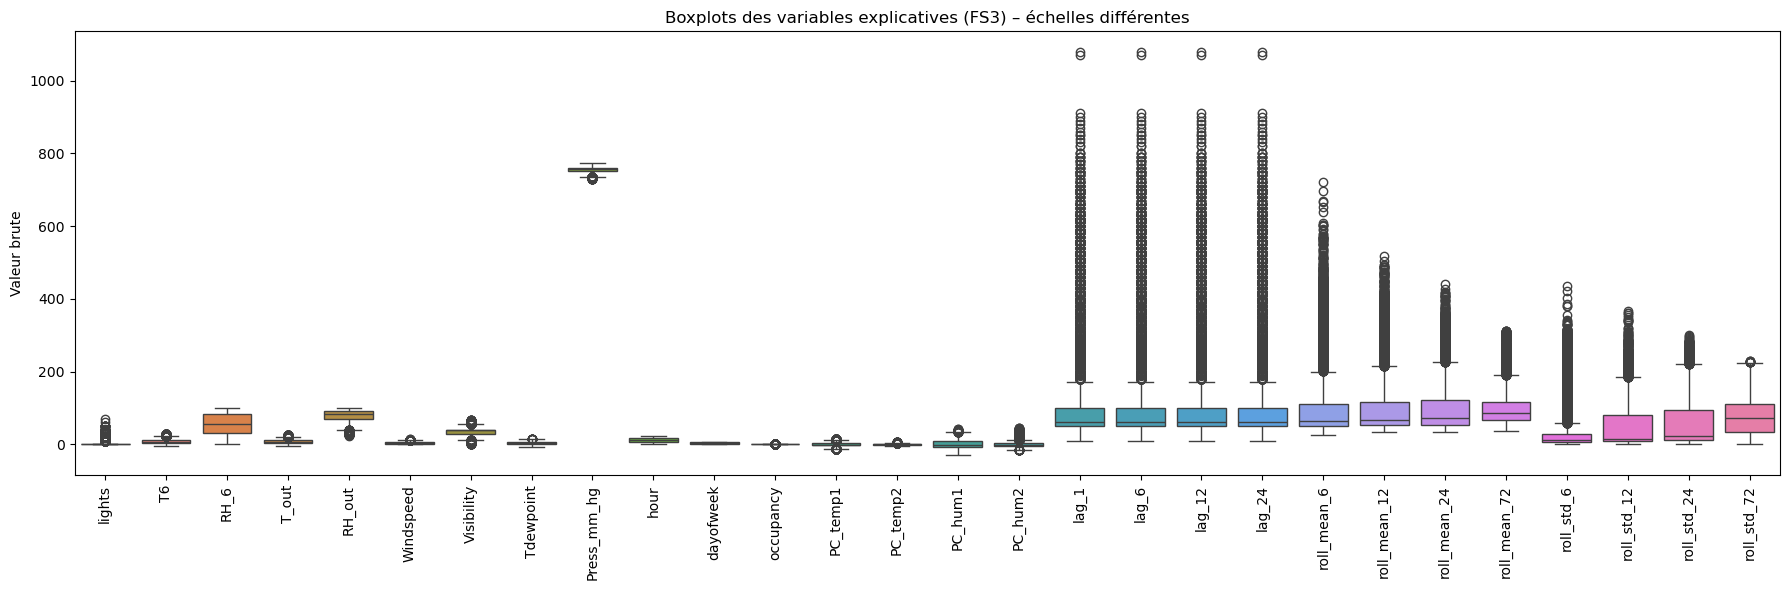

In [43]:
# Boxplots des variables explicatives pour montrer la différence d'échelle
plt.figure(figsize=(18, 6))
sns.boxplot(data=df[feature_sets['FS3']])
plt.xticks(rotation=90)
plt.title("Boxplots des variables explicatives (FS3) – échelles différentes")
plt.ylabel("Valeur brute")
plt.tight_layout()
plt.show()

Comme on peut le voir, les variables ont des **échelles très différentes**, il est donc nécessaire de les mettre sur la même échelle pour éviter que certaines variables dominent les autres dans les modèles.

On va utiliser un **StandardScaler** pour **centrer et réduire** les variables fittées **sur l'échantillon d'apprentissage** pour éviter d'utiliser des informations du test.

In [44]:
from sklearn.preprocessing import StandardScaler

# On normalise selon les features du train uniquement (pas de fuite d'information)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

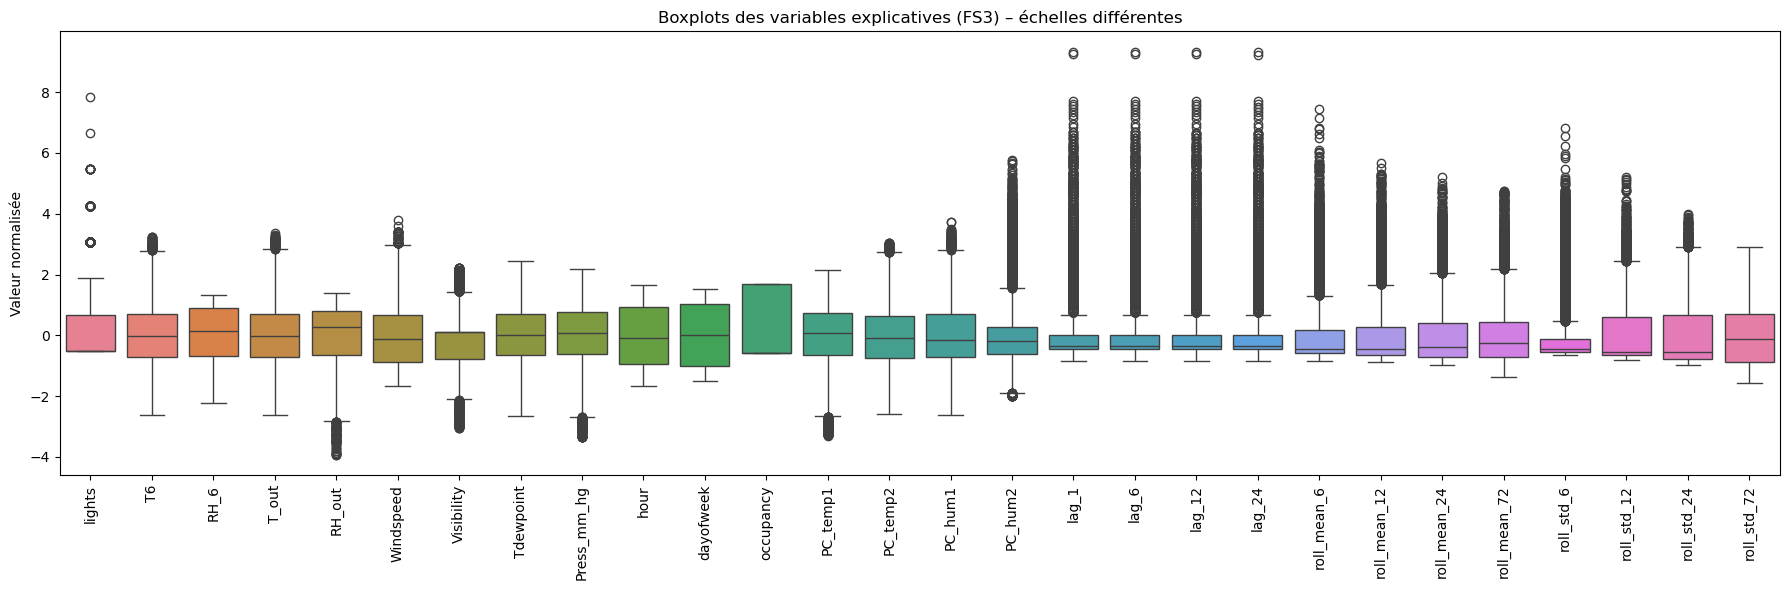

In [46]:
# Convert X_train_scaled back to DataFrame with correct column names for FS3
import pandas as pd

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
plt.figure(figsize=(18, 6))
sns.boxplot(data=X_train_scaled_df[feature_sets['FS3']])
plt.xticks(rotation=90)
plt.title("Boxplots des variables explicatives (FS3) – échelles différentes")
plt.ylabel("Valeur normalisée")
plt.tight_layout()
plt.show()

La différence est claire, on bien normalisé les données.

Comme on va utiliser un **réseau de neuronnes** plus tard, on normalise aussi les cibles `Appliances` et `log_Appliances`.  

Cette **double-normalisation** (X et y) place l’ensemble du problème dans une **zone numérique stable** pour **la descente de gradient**, **accélère la convergence** et permet d’utiliser un **learning rate modéré**.

Nous l'illustrerons ou détaillerons pourquoi plus tard si il reste de la place. 

In [48]:
from sklearn.preprocessing import StandardScaler

# Normalisation des cibles (train/test, Appliances et log_Appliances)

# Initialiser les scalers pour chaque cible
y_scaler = StandardScaler()
y_log_scaler = StandardScaler()

# Fit sur le train uniquement, transform sur train et test
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

y_train_log_scaled = y_log_scaler.fit_transform(y_train_log.values.reshape(-1, 1)).flatten()
y_test_log_scaled = y_log_scaler.transform(y_test_log.values.reshape(-1, 1)).flatten()

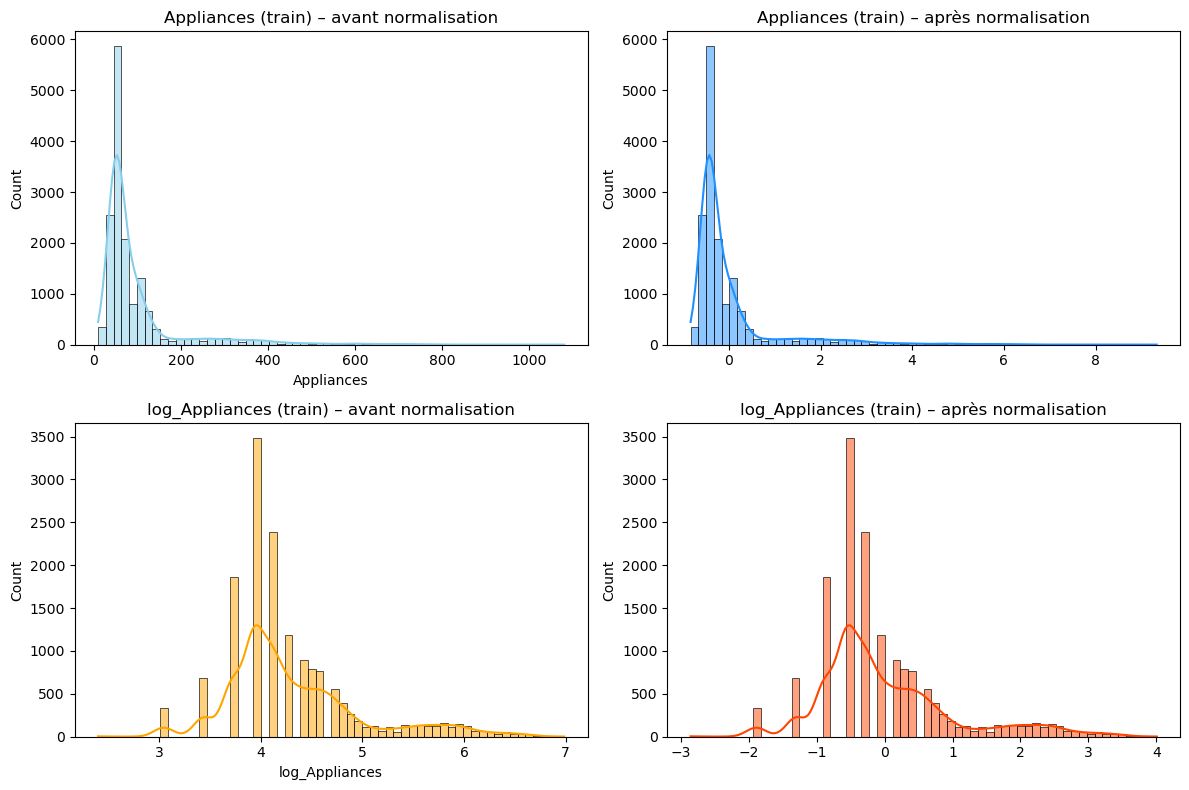

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Distribution originale de la cible Appliances
sns.histplot(y_train, bins=60, kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title("Appliances (train) – avant normalisation")

# Distribution normalisée de la cible Appliances
sns.histplot(y_train_scaled, bins=60, kde=True, ax=axes[0, 1], color='dodgerblue')
axes[0, 1].set_title("Appliances (train) – après normalisation")

# Distribution originale de la cible log_Appliances
sns.histplot(y_train_log, bins=60, kde=True, ax=axes[1, 0], color='orange')
axes[1, 0].set_title("log_Appliances (train) – avant normalisation")

# Distribution normalisée de la cible log_Appliances
sns.histplot(y_train_log_scaled, bins=60, kde=True, ax=axes[1, 1], color='orangered')
axes[1, 1].set_title("log_Appliances (train) – après normalisation")

plt.tight_layout()
plt.show()
